## Dissertation Dataset Exploration
### Gavin Rolls

Now that I've queried and cleaned my data as well as run a few dummy models, I'm going to try to do some data exploration to understand the underlying dataset a little bit better

### Imports and Clean Up

In [362]:
# Library Imports

#Basics
import pandas as pd
import geopandas as gpd
import numpy as np

#Shapely
from shapely import wkt
import shapely.geometry
from shapely.geometry import Polygon, MultiPolygon

#Plots and Stats
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#ML from mljar-supervised
from supervised.automl import AutoML

In [209]:
# Import Cleaned Employment Geography File

empl_geog = gpd.read_file('data/combined_data/empl_geog.geojson')

# WKT strings back to Shapely geometries
empl_geog['overture_building_poly'] = empl_geog['overture_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['osm_building_poly'] = empl_geog['osm_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['place_points'] = empl_geog['place_points'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)

# Convert string representations of lists back to lists
empl_geog['category_list'] = empl_geog['category_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

empl_geog.head()

,LSOA11CD,LSOA11NM_x,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,...,LSOA11NM_y,total,num_overture_buildings,num_osm_buildings,num_places,overture_building_poly,osm_building_poly,place_points,category_list,geometry
0,E01000001,City of London 001A,1465,lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,0,...,City of London 001A,14360,29,86,243,"MULTIPOLYGON (((-0.0968818 51.5148582, -0.0969...","MULTIPOLYGON (((-0.0983297 51.5158158, -0.0983...","MULTIPOINT ((-0.0987982 51.5176724), (-0.09860...","[pub, coffee_shop, immigration_law, shared_off...","POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,E01000002,City of London 001B,1436,lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,0,...,City of London 001B,45605,40,96,419,"MULTIPOLYGON (((-0.0932921 51.5152927, -0.0932...","MULTIPOLYGON (((-0.0945314 51.5147658, -0.0944...","MULTIPOINT ((-0.0958288 51.5168656), (-0.09565...","[business_manufacturing_and_supply, education,...","POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,E01000003,City of London 001C,1346,lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,0,...,City of London 001C,760,10,29,55,"MULTIPOLYGON (((-0.0959197 51.5205155, -0.0961...","MULTIPOLYGON (((-0.0959637 51.5209148, -0.0959...","MULTIPOINT ((-0.0976057 51.5226912), (-0.09757...","[health_and_medical, hospital, parking, indust...","POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,E01000005,City of London 001E,985,lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,0,...,City of London 001E,22735,39,133,534,"MULTIPOLYGON (((-0.07593 51.5108457, -0.076125...","MULTIPOLYGON (((-0.0757822 51.511071, -0.07577...","MULTIPOINT ((-0.0799241 51.5156172), (-0.07992...","[professional_services, dance_club, insurance_...","POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,E01000006,Barking and Dagenham 016A,1703,lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,0,...,Barking and Dagenham 016A,105,0,280,11,None,"MULTIPOLYGON (((0.085895 51.5386732, 0.0859413...","MULTIPOINT ((0.0856198 51.538706), (0.0858424 ...","[landmark_and_historical_building, constructio...","POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."


In [59]:
# Import Category Encoded File

encoded_categories = pd.read_csv('data/combined_data/empl_geog_category_encoded.csv')

#Drop extraneous column
encoded_categories = encoded_categories.drop(columns=['Unnamed: 0'])

#Store category columns
category_columns = encoded_categories.columns[1:]

encoded_categories.head()

,LSOA11CD,category_list_3d_printing_service,category_list_abortion_clinic,category_list_abuse_and_addiction_treatment,category_list_accommodation,category_list_accountant,category_list_acoustical_consultant,category_list_active_life,category_list_acupuncture,category_list_addiction_rehabilitation_center,...,category_list_women's_clothing_store,category_list_women's_health_clinic,category_list_wood_and_pulp,category_list_woodworking_supply_store,category_list_writing_service,category_list_yoga_instructor,category_list_yoga_studio,category_list_youth_organizations,category_list_zoo,category_list_None
0,E01000001,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,E01000002,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,E01000003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E01000005,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,E01000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
# Geometric Features Extraction (copied from earlier)

def extract_multipolygon_features(multipolygon, lsoa_geometry):
    if isinstance(multipolygon, MultiPolygon):
        polygons = list(multipolygon.geoms)
    elif isinstance(multipolygon, Polygon):
        polygons = [multipolygon]
    else:
        return pd.Series({
            'num_polygons': 0,
            'total_area': 0,
            'total_perimeter': 0,
            'area_ratio': 0,
            'avg_area': 0,
            'avg_perimeter': 0
        })

    num_polygons = len(polygons)
    areas = [polygon.area for polygon in polygons]
    perimeters = [polygon.length for polygon in polygons]
    total_area = sum(areas)
    total_perimeter = sum(perimeters)
    avg_area = total_area / num_polygons if num_polygons > 0 else 0
    avg_perimeter = total_perimeter / num_polygons if num_polygons > 0 else 0

    #Built-up area ratio could result in a div by zero error if there are no buildings in an LSOA so this logic has to be included here
    try:
        area_ratio = total_area / lsoa_geometry.area
    except ZeroDivisionError:
        area_ratio = 0

    return pd.Series({
        'num_polygons': num_polygons,
        'total_area': total_area,
        'area_ratio': area_ratio,
        'total_perimeter': total_perimeter,
        'avg_area': avg_area,
        'avg_perimeter': avg_perimeter
    })


In [215]:
#Apply function above

#Both Building Set Geometry Features
osm_geometry_features = empl_geog.apply(
    lambda row: extract_multipolygon_features(row['osm_building_poly'], row['geometry']),
    axis=1
)

empl_geog_osm_features = pd.concat([empl_geog, osm_geometry_features], axis=1)

In [269]:
# Combine Datasets (Same Logic as in EarlyModels.ipynb)

all_data = pd.merge(empl_geog_osm_features, encoded_categories, on='LSOA11CD')

all_data.head()

,LSOA11CD,LSOA11NM_x,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,...,category_list_women's_clothing_store,category_list_women's_health_clinic,category_list_wood_and_pulp,category_list_woodworking_supply_store,category_list_writing_service,category_list_yoga_instructor,category_list_yoga_studio,category_list_youth_organizations,category_list_zoo,category_list_None
0,E01000001,City of London 001A,1465,lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,E01000002,City of London 001B,1436,lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,E01000003,City of London 001C,1346,lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E01000005,City of London 001E,985,lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,E01000006,Barking and Dagenham 016A,1703,lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration and Analysis

### POI Category Analysis (London)

In [223]:
# Most Common Categories

#Get totals
category_totals = encoded_categories.sum().drop('LSOA11CD')

#Sort by most common
category_totals = category_totals.sort_values(ascending=False)

category_types = [
    'restaurant',
    'services',
    'store',
    'shop',
    'market',
    'park',
    'center',
    'school',
    'museum',
    'hospital',
    'clinic',
    'office',
    'gym',
    'church',
    'station',
    'salon',
    'stadium',
    'manufacturer',
]

# Check and print the count for each category type
for category_type in category_types:
    columns = category_totals.index.str.lower().str.endswith(category_type)
    num_columns = columns.sum()
    print(f'Number of {category_type.capitalize()} Categories: {num_columns}')

print('\nExamples:')
print(category_totals.head(10))

Number of Restaurant Categories: 110
Number of Services Categories: 85
Number of Store Categories: 104
Number of Shop Categories: 42
Number of Market Categories: 8
Number of Park Categories: 9
Number of Center Categories: 31
Number of School Categories: 28
Number of Museum Categories: 11
Number of Hospital Categories: 3
Number of Clinic Categories: 8
Number of Office Categories: 6
Number of Gym Categories: 2
Number of Church Categories: 5
Number of Station Categories: 7
Number of Salon Categories: 5
Number of Stadium Categories: 6
Number of Manufacturer Categories: 8

Examples:
category_list_beauty_salon                        8939.0
category_list_professional_services               6155.0
category_list_cafe                                4319.0
category_list_community_services_non_profits      3574.0
category_list_park                                3239.0
category_list_pub                                 3137.0
category_list_church_cathedral                    2958.0
category_list_ho

In [279]:
# Automated Condensing of Column Types

# List all columns
all_columns = encoded_categories.columns.tolist()

# I'll group them by 'suffix' to find commonalities
suffix_groups = {}

# Iterate through columns to identify suffixes
for column in all_columns:
    lower_column = column.lower()
    parts = lower_column.split('_')
    if len(parts) > 1:
        suffix = parts[-1]
        if suffix in suffix_groups:
            suffix_groups[suffix].append(column)
        else:
            suffix_groups[suffix] = [column]
    else:
        # Handle columns without suffixes
        suffix_groups['other'] = suffix_groups.get('other', []) + [column]

# Create a list of DataFrames to concatenate
concatenated_dfs = []

# Iterate through suffix groups and aggregate columns
for suffix, columns in suffix_groups.items():
    if columns:
        if len(columns) == 1:
            # Preserve col name if only one col with suffix
            new_column_name = columns[0].replace('category_list_', '')
            concatenated_dfs.append(encoded_categories[columns].rename(columns={columns[0]: new_column_name}))
        else:
            # Aggregate columns with more than one column in the group
            new_column_name = f'all_{suffix}'
            concatenated_dfs.append(encoded_categories[columns].sum(axis=1).rename(new_column_name))

# Concatenate all DataFrames
condensed_categories = pd.concat(concatenated_dfs, axis=1)

# Print summary information (groups only)
for suffix, columns in suffix_groups.items():
    num_columns = len(columns)
    if num_columns > 1:
        print(f'Number of {suffix.capitalize()} Categories: {num_columns}')

condensed_categories.head()

Number of Service Categories: 81
Number of Clinic Categories: 8
Number of Accommodation Categories: 2
Number of Consultant Categories: 9
Number of Center Categories: 31
Number of Services Categories: 85
Number of Education Categories: 3
Number of Entertainment Categories: 2
Number of Store Categories: 100
Number of Agency Categories: 12
Number of Restaurant Categories: 110
Number of Program Categories: 2
Number of Supplier Categories: 25
Number of Production Categories: 6
Number of Dealer Categories: 14
Number of Manufacturer Categories: 8
Number of Repair Categories: 21
Number of Lounge Categories: 2
Number of Centers Categories: 2
Number of Contractor Categories: 5
Number of Medicine Categories: 6
Number of League Categories: 4
Number of Team Categories: 4
Number of Park Categories: 9
Number of Church Categories: 5
Number of Hospital Categories: 3
Number of Shelter Categories: 2
Number of Studio Categories: 7
Number of Agent Categories: 2
Number of Apartments Categories: 2
Number of 

,LSOA11CD,all_service,all_clinic,abuse_and_addiction_treatment,all_accommodation,accountant,all_consultant,active_life,acupuncture,all_center,...,waxing,welders,well_drilling,wholesale_grocer,wildlife_control,wildlife_sanctuary,wills_trusts_and_probate,winery,wood_and_pulp,None
0,E01000001,12.0,0.0,0.0,2.0,1.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E01000002,21.0,0.0,0.0,1.0,5.0,4.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E01000003,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E01000005,26.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,E01000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [351]:
#Remove all categories that have less than five in London (arbitrary cutoff for now)

column_sums = condensed_categories.iloc[:, 1:].sum()
columns_to_drop = column_sums[column_sums < 5].index.tolist()
print(columns_to_drop)

condensed_categories = condensed_categories.drop(columns=columns_to_drop)

#Store new categories
condensed_category_columns = condensed_categories.columns[1:]

condensed_categories.head()

[]


,LSOA11CD,all_service,all_clinic,all_accommodation,accountant,all_consultant,active_life,acupuncture,all_center,all_services,...,used_vintage_and_consignment,veterinarian,videographer,vitamins_and_supplements,warehouses,waxing,wholesale_grocer,wildlife_sanctuary,wills_trusts_and_probate,winery
0,E01000001,12.0,0.0,2.0,1.0,4.0,0.0,0.0,0.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E01000002,21.0,0.0,1.0,5.0,4.0,0.0,1.0,1.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E01000003,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E01000005,26.0,0.0,1.0,2.0,2.0,2.0,1.0,3.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,E01000006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [267]:
# Join Condensed Version with data (Same Logic as in EarlyModels.ipynb and above)

all_data_condensed_cat = pd.merge(empl_geog_osm_features, condensed_categories, on='LSOA11CD')

all_data_condensed_cat.head()

,LSOA11CD,LSOA11NM_x,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,...,waxing,welders,well_drilling,wholesale_grocer,wildlife_control,wildlife_sanctuary,wills_trusts_and_probate,winery,wood_and_pulp,None
0,E01000001,City of London 001A,1465,lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E01000002,City of London 001B,1436,lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E01000003,City of London 001C,1346,lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E01000005,City of London 001E,985,lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,E01000006,Barking and Dagenham 016A,1703,lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Collinearity Analysis

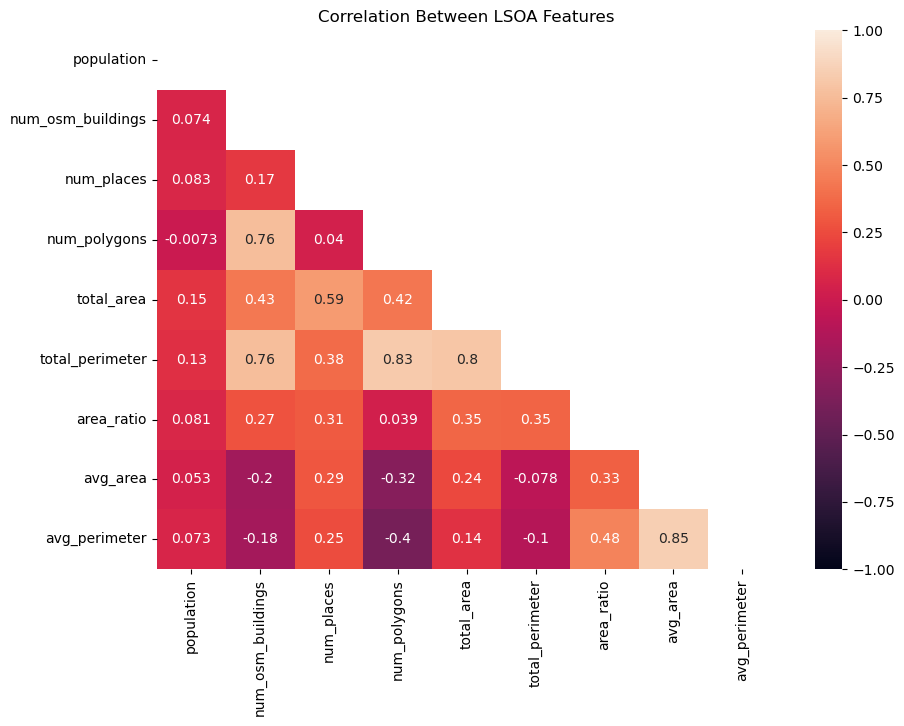

In [339]:
%matplotlib inline 
# Colinearity Matrix - Gonna exclude employment and POI categories in this one because there are SO many

# Choose my columns
selected_columns = [
    'population',
    'num_osm_buildings',
    'num_places',
    'num_polygons',
    'total_area',
    'total_perimeter',
    'area_ratio',
    'avg_area',
    'avg_perimeter'
]

colinearity_features = empl_geog_osm_features[selected_columns]

plt.figure(figsize=(10,7))

# Heatmap
sns.heatmap(colinearity_features.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Between LSOA Features')
plt.show()


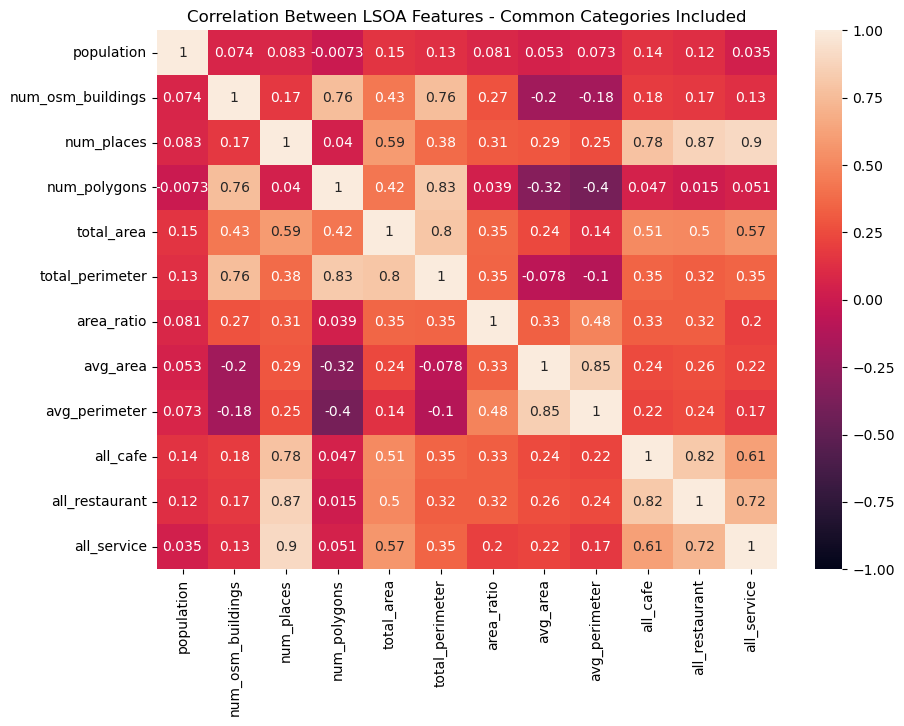

In [349]:
# Test Collinearity on Categorical Variables???

%matplotlib inline 

# Choose my columns
selected_columns = [
    'population',
    'num_osm_buildings',
    'num_places',
    'num_polygons',
    'total_area',
    'total_perimeter',
    'area_ratio',
    'avg_area',
    'avg_perimeter',
    'all_cafe',
    'all_restaurant',
    'all_service',
]

colinearity_features = all_data_condensed_cat[selected_columns]

plt.figure(figsize=(10,7))

# Heatmap
sns.heatmap(colinearity_features.corr(), annot=True, vmin=-1, vmax=1)
plt.title('Correlation Between LSOA Features - Common Categories Included')
plt.show()


### Principal Component Analysis (?)

In [ ]:
# PCA Stuff Here


## AutoML Initial Tests

In [382]:
#AutoML Test

# create training and testing data
features = ['num_polygons', 'total_area', 'total_perimeter', 'area_ratio', 'avg_area', 'avg_perimeter', 'num_osm_buildings', 'num_places', 'population'] + list(category_columns)
target = 'total'

# Split the dataset - 80/20 train test
X_train, X_test, y_train, y_test = train_test_split(all_data[features], all_data[target], test_size=0.2, random_state=42)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="automl_results/first_model/", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f'R^2 Score: {r2}')


Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.
R^2 Score: 0.6203300667146311


/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/supervised/preprocessing/scale.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[4.93155670e+01]
 [5.61404297e+02]
 [1.55706802e+02]
 [6.76826172e+02]
 [1.87971756e+02]
 [7.90662308e+01]
 [6.12119751e+02]
 [9.49957047e+01]
 [1.03793274e+02]
 [2.76714142e+02]
 [6.48762512e+02]
 [3.17940857e+02]
 [4.33025665e+02]
 [5.90699158e+02]
 [4.87578827e+02]
 [2.06957593e+03]
 [4.39620636e+02]
 [3.47898926e+02]
 [4.68185638e+02]
 [5.34298401e+02]
 [5.74899536e+02]
 [2.57875198e+02]
 [3.66316553e+03]
 [5.15003174e+02]
 [2.58861435e+02]
 [1.96900696e+02]
 [1.29405266e+02]
 [1.21226471e+02]
 [2.74786377e+02]
 [6.28814148e+02]
 [1.73812158e+03]
 [9.56545715e+01]
 [1.57593338e+02]
 [6.50553101e+02]
 [4.91329285e+02]
 [3.74398468e+02]
 [3.86998405e+01]
 [1.31176857e+02]
 [3.91145752e+02]
 [1.10827966e+03]
 [1.28376617e+02]
 [2.09897659e+02]
 [9.59695410e+03]
 

In [384]:
#AutoML Test

# create training and testing data
features = ['num_polygons', 'total_area', 'total_perimeter', 'area_ratio', 'avg_area', 'avg_perimeter', 'num_osm_buildings', 'num_places', 'population'] + list(condensed_category_columns)
target = 'total'

# Split the dataset - 80/20 train test
X_train, X_test, y_train, y_test = train_test_split(all_data_condensed_cat[features], all_data_condensed_cat[target], test_size=0.2, random_state=42)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="automl_results/category_combined/", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f'R^2 Score: {r2}')


This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.
R^2 Score: 0.6019314151042121


/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/supervised/preprocessing/scale.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[5.53916054e+01]
 [4.89843658e+02]
 [1.51760620e+02]
 [8.06791565e+02]
 [1.41851639e+02]
 [8.79528961e+01]
 [5.47373901e+02]
 [1.00305908e+02]
 [9.79382248e+01]
 [3.47871704e+02]
 [8.39705505e+02]
 [3.45643219e+02]
 [5.30713562e+02]
 [5.62917114e+02]
 [5.42253967e+02]
 [2.03676208e+03]
 [3.79605469e+02]
 [3.68072205e+02]
 [4.31515503e+02]
 [4.96145477e+02]
 [4.44608276e+02]
 [2.59123703e+02]
 [2.99585181e+03]
 [5.21681213e+02]
 [2.76007385e+02]
 [1.82088913e+02]
 [1.30273895e+02]
 [1.61363205e+02]
 [2.35874130e+02]
 [8.57970398e+02]
 [1.26670642e+03]
 [8.38629074e+01]
 [1.36878510e+02]
 [6.00852051e+02]
 [5.62263489e+02]
 [3.50363525e+02]
 [3.70783958e+01]
 [1.13492714e+02]
 [3.48716370e+02]
 [1.48596130e+03]
 [1.25933853e+02]
 [2.31350464e+02]
 [8.38737695e+03]
 

### Modelling Employment Density vs Raw Employment

In [400]:
# Because LSOAs differ so greatly in employment counts, I will create a new employment density metric and try and run a model based off of that

#This is employees per hectare
#I'm also reprojecting my LSOA areas to British National Grid so I can get accurate area statistics
all_data_condensed_cat['employment_density'] = all_data_condensed_cat['total'] / (all_data_condensed_cat['geometry']).to_crs("EPSG:27700").area

all_data_condensed_cat.head()

,LSOA11CD,LSOA11NM_x,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,...,welders,well_drilling,wholesale_grocer,wildlife_control,wildlife_sanctuary,wills_trusts_and_probate,winery,wood_and_pulp,None,employment_density
0,E01000001,City of London 001A,1465,lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107710
1,E01000002,City of London 001B,1436,lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201621
2,E01000003,City of London 001C,1346,lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013263
3,E01000005,City of London 001E,985,lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.119194
4,E01000006,Barking and Dagenham 016A,1703,lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000728


In [405]:
# Model with Density as the Target

#AutoML Test

# create training and testing data
features = ['num_polygons', 'total_area', 'total_perimeter', 'area_ratio', 'avg_area', 'avg_perimeter', 'num_osm_buildings', 'num_places', 'population'] + list(condensed_category_columns)
target = 'employment_density'

# Split the dataset - 80/20 train test
X_train, X_test, y_train, y_test = train_test_split(all_data_condensed_cat[features], all_data_condensed_cat[target], test_size=0.2, random_state=42)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="automl_results/category_combined_empl_density/", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f'R^2 Score: {r2}')


AutoML directory: automl_results/category_combined_empl_density/
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 157.725382 trained in 0.64 seconds
2_DecisionTree rmse 112.596604 trained in 12.91 seconds
3_Linear rmse 7671286714.419367 trained in 5.7 seconds
* Step default_algorithms will try to check up to 3 models


/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/supervised/preprocessing/scale.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[  9.78629942]
 [ 11.91114874]
 [  3.43438501]
 ...
 [  2.9873857 ]
 [  8.5955245 ]
 [119.83096571]]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/supervised/preprocessing/scale.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[3.89232661e+01]
 [1.81620128e+01]
 [6.56433840e+00]
 [7.48285742e+00]
 [4.85881252e+00]
 [1.88661048e+01]
 [7.62234564e+00]
 [3.72370936e+01]
 [2.41234691e+01]
 [1.84432036e+01]
 [4.73365047e+01]
 [1.22908360e+01]
 [2.57397647e+02]
 [6.09831340e+01]
 [4.19424076e+00]
 [5.43852825e+00]
 [9.33670015e+00]
 [5.01936938e+01]
 [2.29731174e+00]
 [3.94172694e+01

4_Default_Xgboost rmse 82.125861 trained in 10.18 seconds
5_Default_NeuralNetwork rmse 1880.552872 trained in 4.75 seconds
6_Default_RandomForest rmse 97.552861 trained in 13.86 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 80.638421 trained in 0.06 seconds
AutoML fit time: 51.05 seconds
AutoML best model: Ensemble
R^2 Score: 0.4933889833727604


/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/supervised/preprocessing/scale.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[2.74402471e+00]
 [1.48736960e+01]
 [2.43498535e+00]
 [4.51987826e+01]
 [8.99136705e+00]
 [1.60600879e+01]
 [2.72339923e+01]
 [6.62040110e+00]
 [4.01937456e+00]
 [4.10017421e+01]
 [3.61778476e+01]
 [4.46487780e+00]
 [3.32062327e+01]
 [1.60881278e+01]
 [3.77764575e+01]
 [4.91133334e+01]
 [3.83384768e+01]
 [4.12506167e+01]
 [2.34475142e+01]
 [3.82010905e+01]
 [6.58198115e+01]
 [1.23953282e+01]
 [9.02697932e+01]
 [1.12965056e+01]
 [9.68799617e+01]
 [1.61684844e+01]
 [5.70718975e+00]
 [9.23275347e+00]
 [1.11364476e+01]
 [4.37387683e+01]
 [1.53702777e+02]
 [3.84550352e+00]
 [5.82508345e+00]
 [2.47219226e+01]
 [5.75671406e+00]
 [2.00182883e+01]
 [3.01446862e+00]
 [2.09553382e+01]
 [5.47405024e+00]
 [1.20307704e+02]
 [4.05805368e+00]
 [1.00312202e+01]
 [3.10035891e+02]
 